### Clustering of bid requests time-series with Dynamic Time Warping as a measure of similarity

In [ ]:
%matplotlib inline
import os
import glob
import warnings
import fastparquet as fp
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from os.path import join, normpath
from pandasql import sqldf


warnings.filterwarnings("ignore")
pd.options.display.max_columns = None


In [2]:
"""
    Distance estimation
"""
def LB_Keogh(s1, s2, r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [3]:
"""
    Dynamic Time Warping similarity
"""

def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [4]:
"""
    Dynamic Time Warping similarity with window
"""
def DTWDistanceWithWindow(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


In [5]:
"""
    Set dirs
"""
cwd = os.getcwd()
data_dir = join(cwd, 'data')


In [ ]:
"""
    Read data into dataframe
"""

file_in = os.path.join(data_dir, 'load_model_3months_better.csv')
data = pd.read_csv(file_in)
data.columns = [x.lower() for x in data.columns]
data.rename(columns={'index': 'timestamp'}, inplace=True)
data.drop_duplicates(inplace=True)
data.head()

timestamp     power         status  \
0  2017-03-03 14:47:15-08:00  0.000000         PlugIn   
1  2017-03-03 14:47:20-08:00  5.809206  ChargingStart   
2  2017-03-03 14:50:00-08:00  5.809206  ChargingStart   
3  2017-03-03 14:55:00-08:00  5.809206  ChargingStart   
4  2017-03-03 15:00:00-08:00  5.809206  ChargingStart   

                         unitid  
0  0100000100000046495017126501  
1  0100000100000046495017126501  
2  0100000100000046495017126501  
3  0100000100000046495017126501  
4  0100000100000046495017126501

In [36]:
df = data.melt(id_vars=['unitid', 'timestamp', 'status']).loc[:, ['unitid', 'timestamp', 'value']]
df.rename(columns={'value': 'power'}, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

unitid                  timestamp     power
0  0100000100000046495017126501  2017-03-03 14:47:15-08:00  0.000000
1  0100000100000046495017126501  2017-03-03 14:47:20-08:00  5.809206
2  0100000100000046495017126501  2017-03-03 14:50:00-08:00  5.809206
3  0100000100000046495017126501  2017-03-03 14:55:00-08:00  5.809206
4  0100000100000046495017126501  2017-03-03 15:00:00-08:00  5.809206

In [37]:
"""
    Cast to utc timestamp
"""
to_date = ['timestamp']
df[to_date] = df[to_date].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))
df.head()

unitid           timestamp     power
0  0100000100000046495017126501 2017-03-03 22:47:15  0.000000
1  0100000100000046495017126501 2017-03-03 22:47:20  5.809206
2  0100000100000046495017126501 2017-03-03 22:50:00  5.809206
3  0100000100000046495017126501 2017-03-03 22:55:00  5.809206
4  0100000100000046495017126501 2017-03-03 23:00:00  5.809206

In [42]:
"""
    Group data by 5-minute interval getting the average power
"""
df = df.set_index('timestamp').groupby(['unitid', pd.TimeGrouper('5Min')])\
    .agg({'power': np.mean})\
    .reset_index()
df.head(50)

unitid           timestamp     power
0   0100000100000046495017126501 2017-03-03 22:45:00  2.904603
1   0100000100000046495017126501 2017-03-03 22:50:00  5.809206
2   0100000100000046495017126501 2017-03-03 22:55:00  5.809206
3   0100000100000046495017126501 2017-03-03 23:00:00  5.809206
4   0100000100000046495017126501 2017-03-03 23:05:00  5.809206
5   0100000100000046495017126501 2017-03-03 23:10:00  5.809206
6   0100000100000046495017126501 2017-03-03 23:15:00  5.809206
7   0100000100000046495017126501 2017-03-03 23:20:00  5.809206
8   0100000100000046495017126501 2017-03-03 23:25:00  5.809206
9   0100000100000046495017126501 2017-03-03 23:30:00  5.809206
10  0100000100000046495017126501 2017-03-03 23:35:00  5.809206
11  0100000100000046495017126501 2017-03-03 23:40:00  5.809206
12  0100000100000046495017126501 2017-03-03 23:45:00  5.809206
13  0100000100000046495017126501 2017-03-03 23:50:00  5.809206
14  0100000100000046495017126501 2017-03-03 23:55:00  5.809206
15  0100000100000046495017126501 2017-03-04 00:00:00  5.809206
16  0100000100000046495017126501 2017-03-04 00:05:00  5.809206
17  0100000100000046495017126501 2017-03-04 00:10:00  5.809206
18  0100000100000046495017126501 2017-03-04 00:15:00  5.809206
19  0100000100000046495017126501 2017-03-04 00:20:00  5.809206
20  0100000100000046495017126501 2017-03-04 00:25:00  5.809206
21  0100000100000046495017126501 2017-03-04 00:30:00  5.809206
22  0100000100000046495017126501 2017-03-04 00:35:00  5.809206
23  0100000100000046495017126501 2017-03-04 00:40:00  5.809206
24  0100000100000046495017126501 2017-03-04 00:45:00  5.809206
25  0100000100000046495017126501 2017-03-04 00:50:00  5.809206
26  0100000100000046495017126501 2017-03-04 00:55:00  5.809206
27  0100000100000046495017126501 2017-03-04 01:00:00  5.809206
28  0100000100000046495017126501 2017-03-04 01:05:00  5.809206
29  0100000100000046495017126501 2017-03-04 01:10:00  5.809206
30  0100000100000046495017126501 2017-03-04 01:15:00  5.809206
31  0100000100000046495017126501 2017-03-04 01:20:00  5.809206
32  0100000100000046495017126501 2017-03-04 01:25:00  5.809206
33  0100000100000046495017126501 2017-03-04 01:30:00  5.809206
34  0100000100000046495017126501 2017-03-04 01:35:00  5.809206
35  0100000100000046495017126501 2017-03-04 01:40:00  5.809206
36  0100000100000046495017126501 2017-03-04 01:45:00  5.809206
37  0100000100000046495017126501 2017-03-04 02:20:00  0.000000
38  0100000100000046495017126501 2017-03-04 20:20:00  3.136767
39  0100000100000046495017126501 2017-03-04 20:25:00  6.273534
40  0100000100000046495017126501 2017-03-04 20:30:00  6.273534
41  0100000100000046495017126501 2017-03-04 20:35:00  6.273534
42  0100000100000046495017126501 2017-03-04 20:40:00  6.273534
43  0100000100000046495017126501 2017-03-04 20:45:00  6.273534
44  0100000100000046495017126501 2017-03-04 20:50:00  6.273534
45  0100000100000046495017126501 2017-03-04 20:55:00  6.273534
46  0100000100000046495017126501 2017-03-04 21:00:00  6.273534
47  0100000100000046495017126501 2017-03-04 21:05:00  6.273534
48  0100000100000046495017126501 2017-03-04 21:10:00  6.273534
49  0100000100000046495017126501 2017-03-04 21:15:00  6.273534

In [43]:
"""
    Get the date range in order to work on weekly samples
"""
df.timestamp.describe()

count                 2315467
unique                  27306
top       2017-05-19 07:00:00
freq                      482
first     2017-02-24 03:20:00
last      2017-06-15 12:20:00
Name: timestamp, dtype: object

In [276]:
"""
    Get a weekly sample subset
    
"""

from datetime import datetime, timedelta


start_date = '2017-05-08'
date_range = 7

start_str = start_date.split('-')
start = datetime(int(start_str[0]), int(start_str[1]), int(start_str[2]), 0, 0, 0)
end = start + timedelta(days=date_range)

df_s = df.loc[(df.timestamp >= start.strftime('%Y-%m-%d')) & (df.timestamp < end.strftime('%Y-%m-%d')), :]
df_s.timestamp.describe()

count                  224972
unique                   2016
top       2017-05-10 07:15:00
freq                      477
first     2017-05-08 00:00:00
last      2017-05-14 23:55:00
Name: timestamp, dtype: object

In [277]:
df_s.head(30)

unitid           timestamp     power
1430  0100000100040062480017127802 2017-05-08 04:00:00  3.156505
1431  0100000100040062480017127802 2017-05-08 04:05:00  3.156505
1432  0100000100040062480017127802 2017-05-08 04:10:00  3.156505
1433  0100000100040062480017127802 2017-05-08 04:15:00  3.156505
1434  0100000100040062480017127802 2017-05-08 04:20:00  3.156505
1435  0100000100040062480017127802 2017-05-08 04:25:00  3.156505
1436  0100000100040062480017127802 2017-05-08 04:30:00  3.156505
1437  0100000100040062480017127802 2017-05-08 04:35:00  3.156505
1438  0100000100040062480017127802 2017-05-08 04:40:00  3.156505
1439  0100000100040062480017127802 2017-05-08 04:45:00  3.156505
1440  0100000100040062480017127802 2017-05-08 04:50:00  3.156505
1441  0100000100040062480017127802 2017-05-08 04:55:00  3.156505
1442  0100000100040062480017127802 2017-05-08 05:00:00  3.156505
1443  0100000100040062480017127802 2017-05-08 05:05:00  3.156505
1444  0100000100040062480017127802 2017-05-08 05:10:00  3.156505
1445  0100000100040062480017127802 2017-05-08 05:15:00  3.156505
1446  0100000100040062480017127802 2017-05-08 05:20:00  3.156505
1447  0100000100040062480017127802 2017-05-08 05:25:00  3.156505
1448  0100000100040062480017127802 2017-05-08 05:30:00  3.156505
1449  0100000100040062480017127802 2017-05-08 05:35:00  3.156505
1450  0100000100040062480017127802 2017-05-08 05:40:00  3.156505
1451  0100000100040062480017127802 2017-05-08 12:35:00  0.000000
1452  0100000100040062480017127802 2017-05-10 00:30:00  0.000000
1453  0100000100040062480017127802 2017-05-10 06:00:00  3.248525
1454  0100000100040062480017127802 2017-05-10 06:05:00  3.248525
1455  0100000100040062480017127802 2017-05-10 06:10:00  3.248525
1456  0100000100040062480017127802 2017-05-10 06:15:00  3.248525
1457  0100000100040062480017127802 2017-05-10 06:20:00  3.248525
1458  0100000100040062480017127802 2017-05-10 06:25:00  3.248525
1459  0100000100040062480017127802 2017-05-10 06:30:00  3.248525

In [278]:
"""
    Create a time-series in a form of dataframe 
    with 5-minute interval columns
"""
df_ts = df_s.pivot_table(index='unitid', columns='timestamp', values='power').fillna(0.0)
df_ts.columns = df_ts.columns.get_level_values(0)
df_ts.head(30)

timestamp                     2017-05-08 00:00:00  2017-05-08 00:05:00  \
unitid                                                                   
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041062017129602                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   
0100000100080042179017129602                  0.0                  0.0   
0100000100080044845017129602                  0.0                  0.0   
0100000100080046139017129602                  0.0                  0.0   
0100000100080046818017129602                  0.0                  0.0   
0100000100080047998017129602                  0.0                  0.0   
0100000100080048374017129602                  0.0                  0.0   
0100000100080049037017129602                  0.0                  0.0   
0100000100080050065017129602                  0.0                  0.0   
0100000100080050982017129602                  0.0                  0.0   
0100000100080051339017129602                  0.0                  0.0   

timestamp                     2017-05-08 00:10:00  2017-05-08 00:15:00  \
unitid                                                                   
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041062017129602                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   
010

In [287]:
"""
    Create zero padded matrix with all possible
    5-minute intervals between start and end dates,
    except those found in the actual time series
    from the real data
"""
from datetime import datetime, timedelta


seconds = (end - start).total_seconds()
step = timedelta(minutes=5)

columns = np.setdiff1d(
    [(start + timedelta(seconds=x)).strftime('%Y-%m-%d %H:%M%:%S') for x in range(0, int(seconds), int(step.total_seconds()))],
    [x.strftime('%Y-%m-%d %H:%M%:%S') for x in df_ts.columns])

rows = df_s.unitid.unique()
power = pd.DataFrame(
    np.zeros(shape=(len(rows), len(columns))), 
    index=rows, 
    columns=columns
)
power.head(20)

Empty DataFrame
Columns: []
Index: [0100000100040062480017127802, 0100000100040063725017127802, 0100000100040064488017127802, 0100000100050053995017127902, 0100000100050055560017127902, 0100000100050056133017127902, 0100000100050056770017127902, 0100000100050058535017127902, 0100000100050059369017127902, 0100000100050059946017127902, 0100000100050060777017127902, 0100000100050061818017127902, 0100000100050062130017127902, 0100000100050062822017127902, 0100000100050064482017127902, 0100000100070053861017128202, 0100000100070054565017128202, 0100000100070056051017128202, 0100000100080041062017129602, 0100000100080041407017129602]

In [284]:
"""
    Merge the actual data with zero padded matrix,
    in order to get the matrix of a fixed size
"""
df_ts = power.join(df_ts)
df_ts.columns = [pd.to_datetime(x) for x in df_ts.columns]
df_ts.sort_index(axis=1, inplace=True)
df_ts.head(20)

2017-05-08 00:00:00  2017-05-08 00:05:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041062017129602                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   

                              2017-05-08 00:10:00  2017-05-08 00:15:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041062017129602                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   

                              2017-05-08 00:20:00  2017-05-08 00:25:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902    

In [258]:
"""
    Create similarity matrix between all units 
"""
from itertools import combinations, permutations


window_size = 3
dtws = pd.DataFrame([
    [x[0], x[1], LB_Keogh(df_ts[df_ts.index == x[0]].values[0], df_ts[df_ts.index == x[1]].values[0], window_size)]  
    for x in combinations(df_ts.index, 2)
], columns=['unit01', 'unit02', 'dtw_lb'])
dtws

unit01                        unit02    dtw_lb
0  0812031446501535522020151148  0814081223361937480916013639  2.677308
1  0812031446501535522020151148  0814081246101033462317018542  2.677308
2  0812031446501535522020151148  0814081259280637341017014055  2.677308
3  0812031446501535522020151148  0814081730271033461217012216  2.677308
4  0814081223361937480916013639  0814081246101033462317018542  0.000000
5  0814081223361937480916013639  0814081259280637341017014055  0.000000
6  0814081223361937480916013639  0814081730271033461217012216  0.000000
7  0814081246101033462317018542  0814081259280637341017014055  0.000000
8  0814081246101033462317018542  0814081730271033461217012216  0.000000
9  0814081259280637341017014055  0814081730271033461217012216  0.000000

In [259]:
import re


columns = ['unit01', 'unit02', 'dtw_lb']
dtws.loc[:, ['dtw_lb']] = dtws.loc[:, ['dtw_lb']].apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
dtws.loc[:, columns].sort_values(['dtw_lb'], ascending=[1])

unit01                        unit02  dtw_lb
4  0814081223361937480916013639  0814081246101033462317018542     0.0
5  0814081223361937480916013639  0814081259280637341017014055     0.0
6  0814081223361937480916013639  0814081730271033461217012216     0.0
7  0814081246101033462317018542  0814081259280637341017014055     0.0
8  0814081246101033462317018542  0814081730271033461217012216     0.0
9  0814081259280637341017014055  0814081730271033461217012216     0.0
0  0812031446501535522020151148  0814081223361937480916013639     1.0
1  0812031446501535522020151148  0814081246101033462317018542     1.0
2  0812031446501535522020151148  0814081259280637341017014055     1.0
3  0812031446501535522020151148  0814081730271033461217012216     1.0

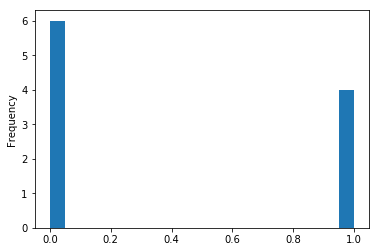

In [260]:
dtws.dtw_lb.plot(kind='hist', bins=20)

Text(0,0.5,'SSE')

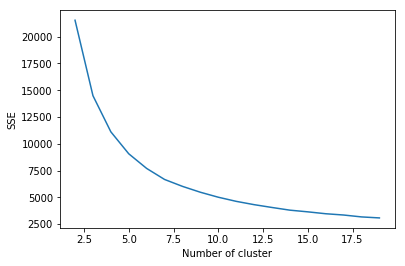

In [44]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering


columns = ['device01', 'device02', 'dtw_lb']
train = pd.concat([
    dtws[columns[:2]].apply(lambda x: x.astype('category')),
    dtws[columns[2:]]], axis=1)\
    .pivot(index='device01', columns='device02')[['dtw_lb']].fillna(1.0)
train.columns = train.columns.get_level_values(1)

X = 1.-train.as_matrix()
sse = {}
for k in range(2, 20):
    # cl = KMeans(n_clusters=k, max_iter=1000)
    cl = KMeans(n_clusters=k)
    cl.fit(X)
    c = pd.DataFrame(cl.predict(X).reshape(-1, 1), columns=['cluster'], index=train.index)
    sse[k] = cl.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")


In [45]:
sse

{2: 21525.0489911357,
 3: 14486.293972965548,
 4: 11113.344549723706,
 5: 9063.506981712047,
 6: 7697.093718065353,
 7: 6668.611579599931,
 8: 6023.9468802868,
 9: 5475.515525106896,
 10: 5011.29628913053,
 11: 4626.92549306587,
 12: 4317.681646909719,
 13: 4054.20613429352,
 14: 3803.5430990060663,
 15: 3646.6439819649077,
 16: 3469.9412968142783,
 17: 3350.512094230903,
 18: 3173.500999608667,
 19: 3080.059558904002}

In [46]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# .apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
columns = ['device01', 'device02', 'dtw_lb']

train = pd.concat([
    dtws[columns[:2]].apply(lambda x: x.astype('category')),
    dtws[columns[2:]]], axis=1)\
    .pivot(index='device01', columns='device02')[['dtw_lb']].fillna(1.0)
train.columns = train.columns.get_level_values(1)
cl = KMeans(n_clusters=9)

c = pd.DataFrame(cl.fit_predict(1.-train.as_matrix()).reshape(-1, 1), columns=['cluster'], index=train.index)
c.groupby(['cluster']).agg({'cluster': 'count'})

cluster
cluster         
0             63
1             63
2             56
3             61
4             69
5             65
6             65
7             65
8             61

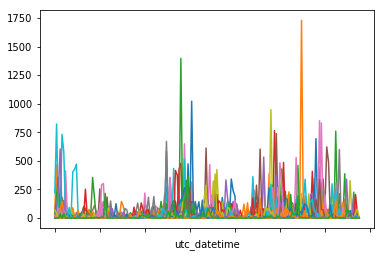

In [47]:
cluster_id = 0
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

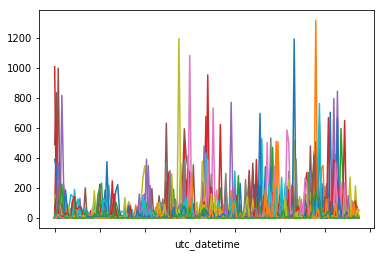

In [48]:
cluster_id = 1
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

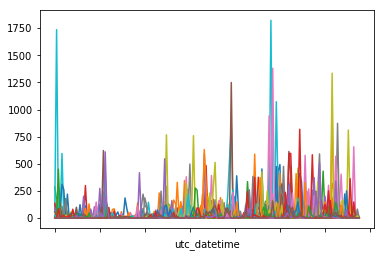

In [49]:
cluster_id = 2
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

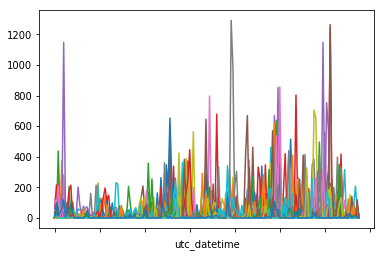

In [50]:
cluster_id = 3
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

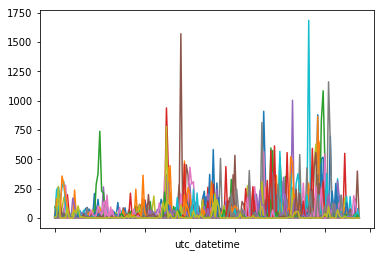

In [51]:
cluster_id = 4
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

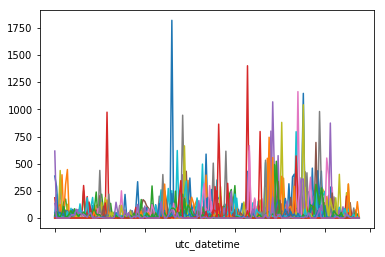

In [52]:
cluster_id = 5
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

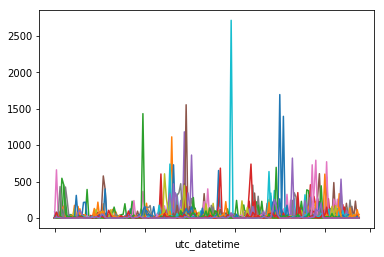

In [53]:
cluster_id = 6
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

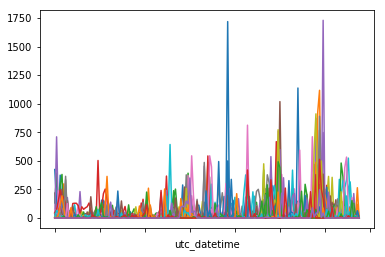

In [54]:
cluster_id = 7
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

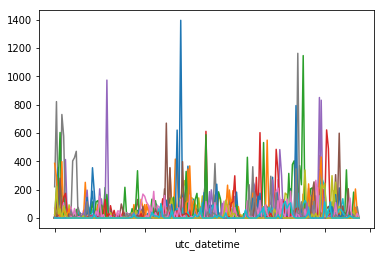

In [41]:
cluster_id = 8
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

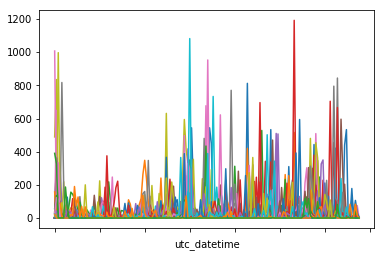

In [42]:
cluster_id = 9
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

In [55]:
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)]

utc_datetime                          2018-05-05 05:00:00  \
device_id                                                   
0cc57ed0-0b64-433b-9ca9-15dd46c35660                  0.0   
12b09428-fb85-4671-878c-72fa674c3e52                  0.0   
19976c1a-171c-4a6e-a6fd-f130ad26eb27                  0.0   
26f7303a-e6e1-47b6-9eb5-c0dfc2771677                  0.0   
2a09c85d-c157-41c9-8c9d-ca84f8f3cf7e                  0.0   
2ae13f71-3070-4de4-be72-f3edca1de4ca                  0.0   
3093f647-59db-4501-9fed-c58f60b43b8a                  0.0   
344ccc9e-d6ce-4924-a417-11d515ee8fb1                  6.0   
3e3647ca-ac02-4608-a584-0d14384422fd                  0.0   
3e42d353-5c15-4798-84e3-046c0b9c4e9b                  0.0   
4ae5a375-a2d5-4ecb-88d3-4bdb3bff0653                 24.0   
4ca1872b-8593-4cc1-a764-bafcbb905700                  0.0   
4d1762bf-c6de-4569-ac0b-cb92fc0f1719                 59.0   
530e5eb9-725d-45ab-bc55-97e51ee69287                  6.0   
6873799e-531a-4e5c-94f1-1c677b7cbcb5                  0.0   
6a281773-9756-4711-8415-59ff18e7c599                 45.0   
78b6f816-fd95-4fab-b045-f941c3e7e63b                  0.0   
7fabce2c-d76e-4d85-91f0-36fe40750a8b                  0.0   
85fed733-a1c3-465c-a3bb-e27447eb345d                  0.0   
95ff23ea-f320-46f4-9aca-2de95a76a529                  0.0   
9cf73b44-2761-4a18-9cbd-e4aa176a9f41                  0.0   
a55661eb-51a7-4eb6-b94e-0ad6a3e73af5                  0.0   
a9b47041-e09c-4389-b02c-baddb971f249                 24.0   
b2147604-a979-4a90-9564-a3b07b7d8cae                 11.0   
b4ae6289-863d-4d47-a493-1d5183e5fc5b                  0.0   
b62a2d30-0521-4a63-a7ec-2985bd733df4                  0.0   
ba693cfe-440b-4023-aeed-982bb6ffa1fe                  0.0   
ba9d293e-6b35-44da-a33d-2e9c1de622a0                  1.0   
be4b8df2-dac6-41af-9e93-f30607520c8a                  0.0   
c4fcabd7-b06c-4086-b343-9766c9add4c0                  0.0   
cb051bb2-2b8b-4d31-9dc0-847bf96e13dc                  0.0   
cbdd9cb4-f510-4edc-8795-43a08b016862                616.0   
de73328d-b6c3-4903-85d4-9713d5a8c3ba                  0.0   
e74b620b-7f25-4b2c-9ad7-ea2f35037e1b                134.0   
edcb37f9-5a4b-4c10-b8a5-745d05974923                  0.0   
eee81b49-93d0-4070-b0ff-4f4fb4138da1                  3.0   
f6452d30-8015-446c-9f50-b7fe9498a340                  0.0   
f93e9cc8-0a93-405c-982f-e9914fadb225                  0.0   

utc_datetime                          2018-05-05 06:00:00  \
device_id                                                   
0cc57ed0-0b64-433b-9ca9-15dd46c35660                  0.0   
12b09428-fb85-4671-878c-72fa674c3e52                  0.0   
19976c1a-171c-4a6e-a6fd-f130ad26eb27                  0.0   
26f7303a-e6e1-47b6-9eb5-c0dfc2771677                  0.0   
2a09c85d-c157-41c9-8c9d-ca84f8f3cf7e                  0.0   
2ae13f71-3070-4de4-be72-f3edca1de4ca                  0.0   
3093f647-59db-4501-9fed-c58f60b43b8a                  0.0   
344ccc9e-d6ce-4924-a417-11d515ee8fb1                  3.0   
3e3647ca-ac02-4608-a584-0d14384422fd                  0.0   
3e42d353-5c15-4798-84e3-046c0b9c4e9b                  0.0   
4ae5a375-a2d5-4ecb-88d3-4bdb3bff0653                  1.0   
4ca1872b-8593-4cc1-a764-bafcbb905700                  2.0   
4d1762bf-c6de-4569-ac0b-cb92fc0f1719                142.0   
530e5eb9-725d-45ab-bc55-97e51ee69287                  0.0   
6873799e-531a-4e5c-94f1-1c677b7cbcb5                  0.0   
6a281773-9756-4711-8415-59ff18e7c599                662.0   
78b6f816-fd95-4fab-b045-f941c3e7e63b                  0.0   
7fabce2c-d76e-4d85-91f0-36fe40750a8b                  0.0   
85fed733-a1c3-465c-a3bb-e27447eb345d                  0.0   
95ff23ea-f320-46f4-9aca-2de95a76a529                  0.0   
9cf73b44-2761-4a18-9cbd-e4aa176a9f41                  0.0   
a55661eb-51a7-4eb6-b94e-0ad6a3e73af5                  0.0   
a9b47041-e09c-4389-b02c-baddb971f249                  5.0   
b2147604-a979-4a90-9564-a3b07b7d8c